<a href="https://colab.research.google.com/github/Narasimhag/FunWithTensorFlow/blob/master/Sarcasm_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict sarcasm in a given sentence.

I don't know about you but ***I hate sarcasm*** :P. That's *why I forced myself* to learn and build a sarcasm detector using neural networks and libraries offered by TensorFlow to enable the process. This is what I'm doing in this notebook.


1.   Get data with a lot of sarcasm headlines and labels classifying them as so.
2.   Split it into training and testing sets.
3.   Pass them into neural net post embedding.
4.   Use the model generated to prodict the sarcasm in a given sentence.

Each code cell is preceded by what's going on in that cell.


Nothing fancy here, just forcing colab to use TensorFlow v2.0

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import json
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

This is a cool way to get our own data into the colab jupyter notebook. We have to store the files we want to get here in an accesible area and put the link here! I'm getting Rishab Mishra's [sarcasm data](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection/home). You can read more [here](https://scholar.google.com/citations?view_op=list_works&hl=en&user=EN3OcMsAAAAJ#d=gs_md_cita-d&u=%2Fcitations%3Fview_op%3Dview_citation%26hl%3Den%26user%3DEN3OcMsAAAAJ%26citation_for_view%3DEN3OcMsAAAAJ%3AqjMakFHDy7sC%26tzom%3D420). '!' is just shell's way of getting things done.

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2020-03-18 20:14:17--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 2404:6800:4008:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2020-03-18 20:14:18 (99.3 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [0]:
vocab_size = 10000
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

Okay. So, we have the file. It contains headlines from sources like The onion and Huffpost, labeled as 1, if they're sarcastic and 0 if they're not. The following code aims to open that json file to get these headlines and labels into separate lists.

In [0]:
with open('/tmp/sarcasm.json', 'r') as datafile:
  data = json.load(datafile)

sentences = []
labels = []

for line in data:
  sentences.append(line['headline'])
  labels.append(line['is_sarcastic'])

Now that we have this data and corresponding labels, we need to identify how to split them into training and test data. To that end, we need to find the total size of the data and say we split them 75, 25.

In [6]:
print(len(sentences))
training_size = int(0.75*(len(sentences)))
# training_size = 20000

train_sentences = sentences[:training_size]
test_sentences = sentences[training_size:]
train_labels = labels[:training_size]
test_labels = labels[training_size:]


26709


Let's do some tokenization. Tensorflow has this class 'Tokenizer' - we imported above - which assigns numeric values to each token that it sees in the sentences. Say, a sentence is like this, "Jack and Jill went up the hill", Tokenizer splits them into a dict, mapping each word to a unique number like this, `{'Jack': 1, 'Jill': 3, 'went': 4, 'up': 2, 'the': 5, 'hill': 6} `. We can then use these numbers in a neural network. 

---
But wait, it maps words in our training data to numbers which we pass to our neural network, well and good. But what if our test data contains unknown words which we did not encounter in the training data? While NLP offers multiple ways to handle this, TensorFlow offers a placeholder, an out of vocabulary token, which we can give while it is mapping values to the training sentences. 
We can see this mapping by printing out the word index.

---

All these things are represented in the following code.


In [0]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
# print(word_index)

Cool. We now have the mapping for words. But sentences are not just words. They're are unique ordering of words, a sequence. And all sequences are not of same length, so we pad sentences which are shorter either pre(that is in front) or post(at the end). We can also truncate sentences to a certain size. The following code shows all these features.

In [0]:
train_seq = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_seq = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

And to pass them to TF model methods, we convert them to Numpy arrays. 

In [0]:
import numpy as np
train_padded = np.array(train_padded)
train_labels = np.array(train_labels)
test_padded = np.array(test_padded)
test_labels = np.array(test_labels)

Okay. The neural net enters the game. We build a simple sequential neural net with an embedding first layer and fully connected hidden and output layers. We also do Global average pooling. Fancy words. We assigned some numbers to words in sentences, now we are passing them to a neural net, are expecting magic to happen. But how do some numbers in a neural net know if the sentiment is sarcastic or not? 


---



This is where embedding comes into play. We are plotting these words labelled as 'Sarcastic' and 'Not Sarcastic' in a multi dimensional space (similar to 2D,  but scaled to Interstellar level) and as we train, we learn what directions in this multi dimensional space should look like. Now when we give a word to a fully trained network, it will plot that on to this multi dimensional space, sum the vectors up and find if it is leaning towards the sarcastic or not sarcastic. 


---
The following code aims to implement these ideas. The first layer is the embedding layer, which learns direction of each word every epoch. Next layer is global average pooling, adding up the vectors. Next layers are fully connected layers with 'Relu' and 'Sigmoid' activation functions.


In [0]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, 16, input_length = max_length),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(24, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [12]:
num_epochs = 20
train_it = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(test_padded, test_labels), verbose=2)

Train on 20031 samples, validate on 6678 samples
Epoch 1/20
20031/20031 - 3s - loss: 0.6625 - accuracy: 0.5932 - val_loss: 0.5618 - val_accuracy: 0.7526
Epoch 2/20
20031/20031 - 3s - loss: 0.4100 - accuracy: 0.8360 - val_loss: 0.3727 - val_accuracy: 0.8440
Epoch 3/20
20031/20031 - 2s - loss: 0.2961 - accuracy: 0.8815 - val_loss: 0.3463 - val_accuracy: 0.8540
Epoch 4/20
20031/20031 - 2s - loss: 0.2467 - accuracy: 0.9036 - val_loss: 0.3416 - val_accuracy: 0.8573
Epoch 5/20
20031/20031 - 2s - loss: 0.2123 - accuracy: 0.9174 - val_loss: 0.3440 - val_accuracy: 0.8559
Epoch 6/20
20031/20031 - 3s - loss: 0.1864 - accuracy: 0.9297 - val_loss: 0.3570 - val_accuracy: 0.8571
Epoch 7/20
20031/20031 - 3s - loss: 0.1657 - accuracy: 0.9373 - val_loss: 0.4089 - val_accuracy: 0.8369
Epoch 8/20
20031/20031 - 3s - loss: 0.1477 - accuracy: 0.9464 - val_loss: 0.3864 - val_accuracy: 0.8528
Epoch 9/20
20031/20031 - 2s - loss: 0.1305 - accuracy: 0.9536 - val_loss: 0.4105 - val_accuracy: 0.8498
Epoch 10/20
200

I took number of epochs to be 20. Am I right? Or are you right for calling me wrong? There is no right answer, as many people debate over this. Here is a nice article in [Towards Data Science](https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9) blog. But in this case (run the cell above), you might be right! One factor is performace on validation data, and we see it dropping after epoch number 4. So maybe, we should limit the number of epochs to 5? What do you think?

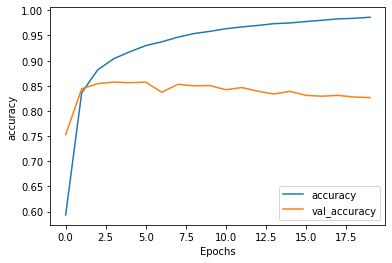

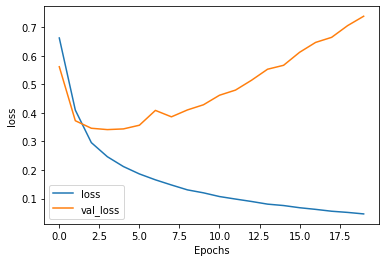

In [13]:
def graph_it(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
graph_it(train_it, "accuracy")
graph_it(train_it, "loss")

In [14]:
pred_sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
pred_sequences = tokenizer.texts_to_sequences(pred_sentence)
pred_padded = pad_sequences(pred_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(pred_padded))

[[0.9433408 ]
 [0.00129842]]


As we can see, in the prediction example above, the neural net classifies the first sentence as 'Sarcastic' and the second one not so much. For fun, why don't you change the sentences in pred_sentence list and see how the model does!

---

This concludes my coding and commentary for Sarcasm detector. Thanks @lmoroney for guidance!